## ICESat-2 ATL03 SlideRule Demo

Plot ATL03 data with different classifications for a region over the Grand Mesa, CO region 

- [ATL08 Land and Vegetation Height product](https://nsidc.org/data/atl08) photon classification
- Experimental YAPC (Yet Another Photon Classification) photon-density-based classification

### What is demonstrated

* The `icesat2.atl03sp` API is used to perform a SlideRule parallel subsetting request of the Grand Mesa region
* The `earthdata.cmr` API's is used to find specific ATL03 granules corresponding to the Grand Mesa region
* The `matplotlib` package is used to plot the ATL03 data subset by SlideRule

In [105]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sliderule import sliderule, icesat2, earthdata
import geopandas as gpd
from datetime import datetime
from datetime import timedelta
import json
import math

In [3]:
url = "slideruleearth.io"
icesat2.init(url, verbose=False)
asset = "icesat2"

### Retrieve ATL03 elevations with several classification options

For two region of interest (blackrock, utqiagvik)

In [28]:
########## SET PARAMETERS ######################

###### Region of interest #########
region = "utqiagvik" # (blackrock, utqiagvik)


##### Read input parameters from .json files #####
poly_fn = f"../../data/bbox_{region}.geojson"

pregion = gpd.read_file(poly_fn)
poly = sliderule.toregion(pregion)["poly"]

# Opening JSON file
f = open("../../data/icesat2_tracks.json")
data = json.load(f)

granule_id = data[region]['granule_id']
track = int(data[region]['beam'][2])
pair = 0 if data[region]['beam'][3]=="l" else 1

time_start = datetime.strptime(granule_id[6:14], "%Y%m%d").strftime("%Y-%m-%d")
time_end = (datetime.strptime(granule_id[6:14], "%Y%m%d") + timedelta(days=1)).strftime("%Y-%m-%d")
rgt = int(granule_id[21:25])
cycle = int(granule_id[25:27])

########## SET PARAMETERS ######################

## Calculate ATL06-SR Elevations from ATL03 Photons using SlideRule

In [51]:
%%time

##### Set ATL03 sp parameters ##############################
# build sliderule parameters for ATL03 subsetting request
# SRT_LAND = 0
# SRT_OCEAN = 1
# SRT_SEA_ICE = 2
# SRT_LAND_ICE = 3
# SRT_INLAND_WATER = 4
parms = {
    # processing parameters
    "srt": 2,
    "len": 40,
    "res": 20,
    "track": track,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True,
    # all photons
    "cnf": 0,
    "cnt": 5,
    "atl03_geo_fields": ["ref_azimuth", "ref_elev", "geoid"],
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0), 
}

# ICESat-2 data release
release = '006'
# region of interest

# find granule for each region of interest
granules_list = earthdata.cmr(short_name='ATL03', polygon=poly, time_start=time_start, time_end=time_end, version=release)

# create an empty geodataframe
parms["poly"] = poly
# gdf = icesat2.atl03sp(parms, asset=asset, version=release, resources=granules_list)
gdf = icesat2.atl03sp(parms, asset=asset, resources=granules_list)


CPU times: user 2min 57s, sys: 4.99 s, total: 3min 2s
Wall time: 3min 6s


In [30]:
# Reduce dataframe for a single beam
def reduce_dataframe(gdf, RGT=None, GT=None, track=None, pair=None, cycle=None, beam='', crs=4326):
    # convert coordinate reference system
    D3 = gdf.to_crs(crs)
    # reduce to reference ground track
    if RGT is not None:
        D3 = D3[D3["rgt"] == RGT]
    # reduce to ground track (gt[123][lr]), track ([123]), or pair (l=0, r=1) 
    gtlookup = {icesat2.GT1L: 1, icesat2.GT1R: 1, icesat2.GT2L: 2, icesat2.GT2R: 2, icesat2.GT3L: 3, icesat2.GT3R: 3}
    pairlookup = {icesat2.GT1L: 0, icesat2.GT1R: 1, icesat2.GT2L: 0, icesat2.GT2R: 1, icesat2.GT3L: 0, icesat2.GT3R: 1}
    if GT is not None:
        D3 = D3[(D3["track"] == gtlookup[GT]) & (D3["pair"] == pairlookup[GT])]
    if track is not None:
        D3 = D3[D3["track"] == track]
    if pair is not None:
        D3 = D3[D3["pair"] == pair]
    # reduce to weak or strong beams
    # tested on cycle 11, where the strong beam in the pair matches the spacecraft orientation.
    # Need to check on other cycles
    if (beam == 'strong'):
        D3 = D3[D3['sc_orient'] == D3['pair']]
    elif (beam == 'weak'):
        D3 = D3[D3['sc_orient'] != D3['pair']]
    # reduce to cycle
    if cycle is not None:
        D3 = D3[D3["cycle"] == cycle]
    # otherwise, return both beams
    
    D3['x_atc'] = D3['segment_dist']+D3['distance']-np.min(D3['segment_dist'])

    # compute orthometric heights using the onboard geoid model (EGM08)
    D3['height_ortho'] = D3['height'] - D3['geoid']
    
    return D3

In [31]:
beam_type = 'strong'
project_srs = "EPSG:4326" #"EPSG:26912+EPSG:5703"
D3 = reduce_dataframe(gdf, RGT = rgt, track=track, pair = pair, beam=beam_type, crs=project_srs)

In [33]:
print(len(D3))
D3.head()

933620


,solar_elevation,background_rate,segment_id,track,segment_dist,sc_orient,cycle,rgt,atl03_cnf,atl08_class,...,height,distance,ref_azimuth,ref_elev,geoid,pair,geometry,spot,x_atc,height_ortho
time,,,,,,,,,,,,,,,,,,,,,
2022-04-17 01:15:52.821399040,23.647131,4.383076e+06,603405,1,1.208686e+07,0,15,381,0,4,...,46.266670,-9.083188,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56400),1,-9.083188,47.466770
2022-04-17 01:15:52.821399040,23.647131,4.383076e+06,603405,1,1.208686e+07,0,15,381,1,4,...,3.893142,-8.968743,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-8.968743,5.093244
2022-04-17 01:15:52.821399040,23.647131,4.383076e+06,603405,1,1.208686e+07,0,15,381,4,1,...,-1.894285,-8.953404,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-8.953404,-0.694184
2022-04-17 01:15:52.821399040,23.647131,4.383076e+06,603405,1,1.208686e+07,0,15,381,0,4,...,-107.598091,-8.667858,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-8.667858,-106.397987
2022-04-17 01:15:52.821399040,23.647131,4.383076e+06,603405,1,1.208686e+07,0,15,381,0,4,...,-115.631218,-8.646224,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-8.646224,-114.431114


In [37]:
D3.keys()

Index(['solar_elevation', 'background_rate', 'segment_id', 'track',
       'segment_dist', 'sc_orient', 'cycle', 'rgt', 'atl03_cnf', 'atl08_class',
       'snowcover', 'relief', 'yapc_score', 'quality_ph', 'landcover',
       'height', 'distance', 'ref_azimuth', 'ref_elev', 'geoid', 'pair',
       'geometry', 'spot', 'x_atc', 'height_ortho'],
      dtype='object')

### Plot the ATL08 classifications

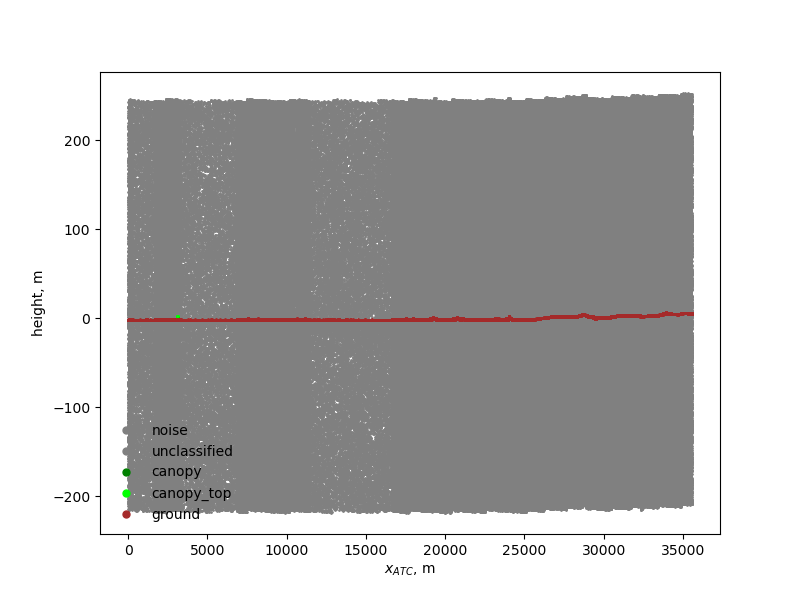

In [34]:
plt.figure(figsize=[8,6])

colors={0:['gray', 'noise'], 
        4:['gray','unclassified'],  
        2:['green','canopy'], 
        3:['lime', 'canopy_top'], 
        1:['brown', 'ground']}
d0=np.min(D3['x_atc'])
for class_val, color_name in colors.items():
    ii=D3['atl08_class']==class_val
    plt.plot(D3['x_atc'][ii]-d0, D3['height'][ii],'o', 
         markersize=1, color=color_name[0], label=color_name[1])
hl=plt.legend(loc=3, frameon=False, markerscale=5)
# plt.gca().set_xlim([26000, 30000])
# plt.gca().set_ylim([2950, 3150])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');

### Plot photon confidence

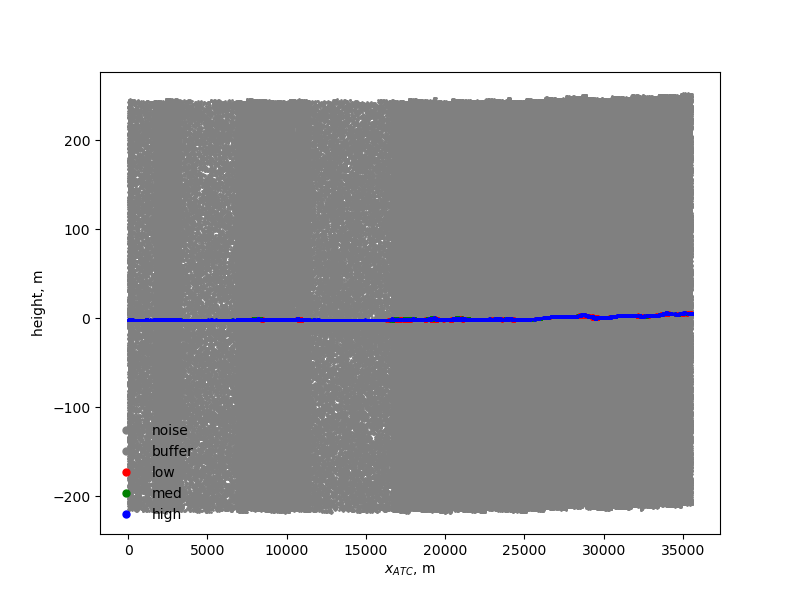

In [39]:
plt.figure(figsize=[8,6])

colors={0:['gray', 'noise'], 
        1:['gray','buffer'],  
        2:['red','low'], 
        3:['green', 'med'], 
        4:['blue', 'high']}
d0=np.min(D3['x_atc'])
for class_val, color_name in colors.items():
    ii=D3['atl03_cnf']==class_val
    plt.plot(D3['x_atc'][ii]-d0, D3['height'][ii],'o', 
         markersize=1, color=color_name[0], label=color_name[1])
hl=plt.legend(loc=3, frameon=False, markerscale=5)
# plt.gca().set_xlim([26000, 30000])
# plt.gca().set_ylim([2950, 3150])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');

### Plot the YAPC classifications

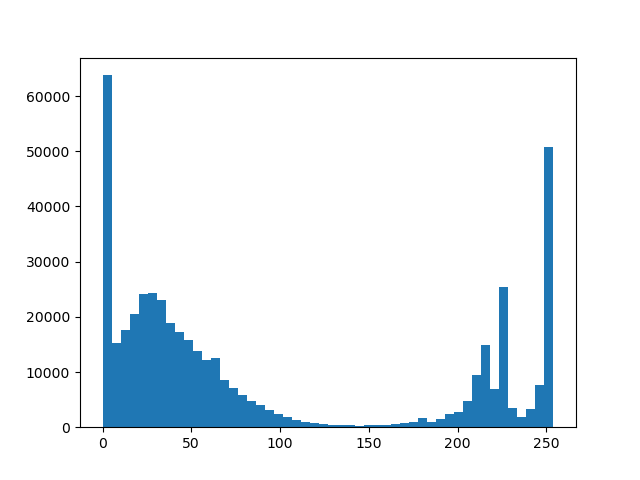

In [10]:
plt.figure()
plt.hist(D3['yapc_score'], bins = 50);

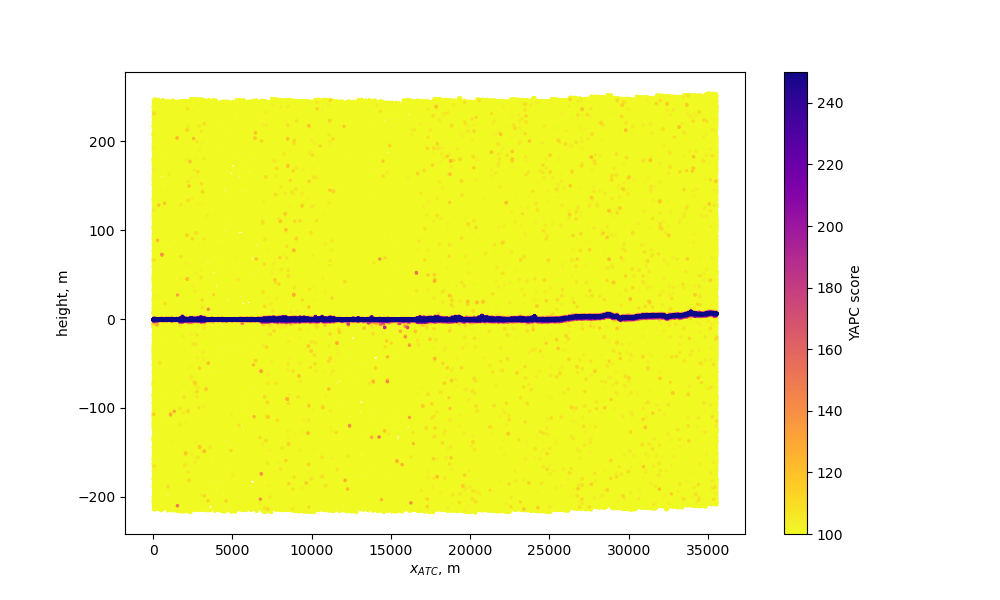

In [35]:
plt.figure(figsize=[10,6])

d0=np.min(D3['x_atc'])
ii=np.argsort(D3['yapc_score'])
plt.scatter(D3['x_atc'][ii] - d0,
    D3['height_ortho'][ii],2, c=D3['yapc_score'][ii],
    vmin=100, vmax=250,cmap='plasma_r')
plt.colorbar(label='YAPC score')
# plt.gca().set_xlim([0, 5000])
# plt.gca().set_ylim([2950, 3150])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');

0.24211651
0.21928218
0.19786233
0.18233867
0.1638609
0.13659167


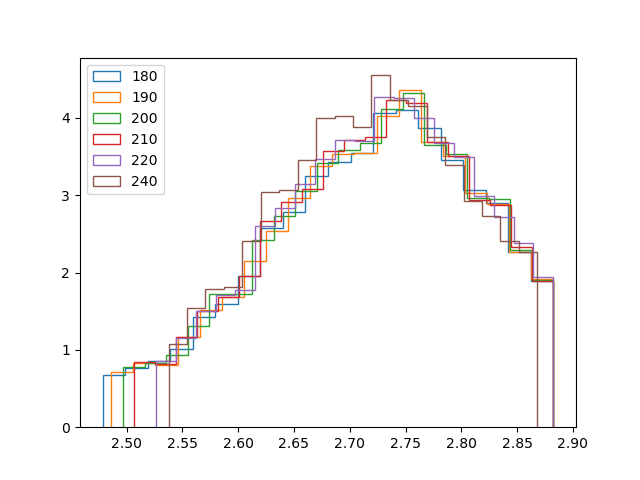

In [282]:
plt.figure()

for yapc_threshold in [180, 190, 200, 210, 220, 240]: 
    
    
    df = D3[(D3['x_atc'] > 27000) & (D3['x_atc'] < 28000)]
    signal = df['yapc_score'] > yapc_threshold
    
    df = df[signal]
    hmean = np.mean(df['height_ortho'])
    hstd = np.std(df['height_ortho'])/2
    hrange = (hmean-hstd, hmean+hstd)
    hrange = (np.quantile(df['height_ortho'], 0.1), np.quantile(df['height_ortho'], 0.9))
    
#     np.hist()
    
    plt.hist(df.loc[:, 'height_ortho'].values, histtype = "step", label = yapc_threshold,
             range = hrange, bins = 20, density = True);
    
    print(df.loc[:, 'height_ortho'].std())
    
plt.legend()

In [91]:
yapc_steps = np.arange(160, 250, 10) #[180, 190, 200, 210, 220, 230, 240]

xbin = 500
x_steps = np.arange(0, 25000, xbin)

array_std = np.zeros((len(yapc_steps), len(x_steps)))
array_mean = np.zeros((len(yapc_steps), len(x_steps)))

xx, yy = np.meshgrid(x_steps+xbin/2, yapc_steps+5)

for i, x1 in enumerate(x_steps): #every 1 km
    
    for j, yapc_threshold in enumerate(yapc_steps):
        
        df = D3[(D3['x_atc'] >= x1) & (D3['x_atc'] < x1+xbin)]
        signal = df['yapc_score'] > yapc_threshold

        df = df[signal]
        hmean = np.mean(df['height_ortho'])
        hstd = np.std(df['height_ortho'])
                     
        array_mean[j, i] = hmean
        array_std[j,i ] = hstd

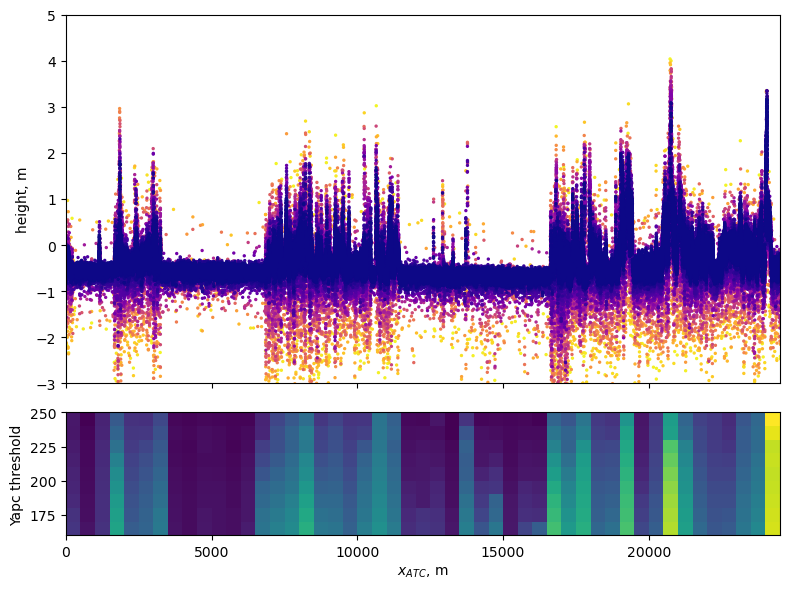

In [92]:
fig, ax = plt.subplots(2,1,figsize=[8,6], sharex = True, height_ratios=[3, 1])

yapc_threshold = 160
signal = D3['yapc_score'] > yapc_threshold

df = D3[signal]

d0=np.min(df['x_atc'])
ii=np.argsort(df['yapc_score'])
sc = ax[0].scatter(df['x_atc'][ii] - d0, df['height_ortho'][ii],2, c=df['yapc_score'][ii],
    vmin=yapc_threshold, vmax=250,cmap='plasma_r')
# fig.colorbar(sc, ax = ax[0], label='YAPC score')
ax[0].set_ylabel('height, m')
ax[0].set_ylim(-3, 5)

ax[1].pcolormesh(xx, yy, array_std)
ax[1].set_xlabel('$x_{ATC}$, m')
ax[1].set_xlim(x_steps[0], x_steps[-1])
ax[1].set_ylabel("Yapc threshold")
plt.tight_layout()

### Calculate fitting (based on Nathan's code)

In [113]:
#Code to fit a specific surface distribution to ATL03 photon cloud

#Import modules
%load_ext autoreload
%autoreload 2


import earthaccess
from datetime import datetime
import numpy as np
import is2_model as is2m
import h5py
import pdb  #python debugger
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import interpolate
from scipy.signal import find_peaks, resample, resample_poly
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
#Set options for curve fitting and photon selection
fit_opts = {'ftol': 0.01, 'max_nfev': 500, 'xtol': 0.01}
surface_fitting_method = 'Lognormal'  #'Gaussian' or 'Lognormal'

In [115]:
yapc_steps = np.arange(180, 250, 30) #[180, 190, 200, 210, 220, 230, 240]

xbin = 2000
x_steps = np.arange(0, 25000, xbin)

for i, x1 in enumerate(x_steps): #every 1 km
    
    plt.figure()
    
    for j, yapc_threshold in enumerate(yapc_steps):
        
        df = D3[(D3['x_atc'] >= x1) & (D3['x_atc'] < x1+xbin)]
        signal = df['yapc_score'] > yapc_threshold

        df = df[signal]
        ph_height = df['height_ortho'].values
        ph_mean = np.mean(df['height_ortho'])
        ph_std = np.std(df['height_ortho'])

        nrb = 500
        rb_res = 0.01
        track_point = ph_mean
        range_bins_m = np.arange(1, nrb) * rb_res - (nrb-1)/2*rb_res - ph_mean #(nrb-1)/3*rb_res  # Set range bins with 3 cm resolution
        wf = np.histogram(ph_height-ph_mean,bins=range_bins_m)
        WF_norm_this = wf[0][:]/np.max(wf[0][:])
        wf_rb = wf[1][:]


        # Calculate lognormal fit

        range_bins_m_hr = np.arange(1, nrb*5) * rb_res/5 - (5*nrb-1)/2*rb_res/5 - ph_mean  # Set range bins with 5x rb_res cm resolution for use when generating pulse shape and distributions
        range_bins_unit = np.arange(1, nrb)

        tracker = lambda xdata, *p: is2m.is2modelfit(xdata, p,range_bins_m_hr)

        rb_use = range_bins_m[0:np.size(WF_norm_this)]
        x0 = np.asarray([1.0, 0, ph_std])  # y scale factor, x shift (in meters), roughness
        lb = x0 - [0.05, 0.5, 0.3]
        ub = x0 + [0.05, 0.5, 0.3]
        if lb[2] < 0:
            lb[2] = 0.005
        GSFC_optimal, GSFC_cov = curve_fit(tracker, rb_use, WF_norm_this, x0, bounds=(lb, ub), method='trf',  **fit_opts)


        GSFC_fit = is2m.is2modelfit(rb_use, GSFC_optimal,range_bins_m_hr)
        # Calculate sum of squared residuals
        GSFC_resnorm = np.sum((WF_norm_this - GSFC_fit)**2)


        #dual_Gaussian_fit = weight1*1/(np.sqrt(2*np.pi)*w1) * np.exp(-0.5*(xin-m1)**2/(w1)**2) + weight2*1/(np.sqrt(2*np.pi)*w2) * np.exp(-0.5*(xin-m2)**2/(w2)**2)
        #dual_Gaussian_fit = dual_Gaussian_fit/np.max(dual_Gaussian_fit)
        #surf_pdf = dual_Gaussian_fit
        ####Generate IS-2 transmit pulse shape and convolve with Gaussian
        #mu = 0.0
        #sigma = 0.116767  #sigma of Gaussian in meters  
        #tau = 9.92750  #exponential relaxation time in meters
        #xin = wf_rb[0:np.size(wf[0][:])]
        #taufit_hr = xin
        #taufit = xin
        ##Convert range bin times to x values in meters with mean of x at tau=0
        #mean_xmg = mu + 1/tau
        #xmgtau = taufit_hr + mean_xmg
        #yy = tau/2*np.exp(tau/2*(2*mu + tau*sigma**2 - 2*xmgtau))*scipy.special.erfc( (mu + tau*sigma**2 - xmgtau) / (np.sqrt(2)*sigma) )


        #power = np.convolve(surf_pdf,yy)
        ## Change axis size after convolution
        #Taxis=np.arange(0,len(power))*(taufit[1]-taufit[0]) + taufit[0]*2

        ##  Get convolved power matrix to same size as input
        #startloc = np.argmin(np.abs(Taxis - taufit[0])) # finds location of taufit start on Taxis
        #power_final = power[startloc:startloc+len(taufit)]

        ##  normalize, remove negative values
        #power_final = power_final/np.max(power_final)
        #power_final[power_final < 0] = 0
        #dual_Gaussian_fit = power_final / np.max(power_final)
        
        
        
        
        
        
        
        # Calculate lognormal or Gaussian fit

        range_bins_m_hr = np.arange(1, nrb*5) * rb_res/5 - (5*nrb-1)/2*rb_res/5 - ph_mean  # Set range bins with 5x rb_res cm resolution for use when generating pulse shape and distributions
        range_bins_unit = np.arange(1, nrb)

        tracker = lambda xdata, *p: is2m.is2modelfit_nonnormalized(xdata, p,range_bins_m_hr)

        rb_use = range_bins_m[0:np.size(WF_norm_this)]

        if surface_fitting_method == 'Lognormal':  
            fit_method = 1
        if surface_fitting_method == 'Gaussian':
            fit_method = 0


        x0 = np.asarray([fit_method, 0, ph_std])  # Fit method, x shift (in meters), roughness
        lb = x0 - [0.05, 0.5, 0.3]
        ub = x0 + [0.05, 0.5, 0.3]
        if lb[2] < 0:
            lb[2] = 0.005
        GSFC_optimal, GSFC_cov = curve_fit(tracker, rb_use, WF_norm_this, x0, bounds=(lb, ub), method='trf',  **fit_opts)


        GSFC_fit = is2m.is2modelfit_nonnormalized(rb_use, GSFC_optimal,range_bins_m_hr)
        # Calculate sum of squared residuals
        GSFC_resnorm = np.sum((WF_norm_this - GSFC_fit)**2)


        #####Run again with Gaussian fit
        x0g = np.asarray([0, 0, ph_std])  # Fit method, x shift (in meters), roughness
        lb[0]=0
        ub[0] = 1
        GSFC_optimal_Gaussian, GSFC_cov_Gaussian = curve_fit(tracker, rb_use, WF_norm_this, x0g, bounds=(lb, ub), method='trf',  **fit_opts)
        GSFC_fit_Gaussian = is2m.is2modelfit_nonnormalized(rb_use, GSFC_optimal_Gaussian,range_bins_m_hr)
        # Calculate sum of squared residuals
        GSFC_resnorm_Gaussian = np.sum((WF_norm_this - GSFC_fit_Gaussian)**2)
        
        
        p1b,=plt.plot(wf_rb[0:np.size(wf[0][:])],WF_norm_this,'-o',label='IS-2 Photon distribution')
    
        p1a,=plt.plot(rb_use,GSFC_fit,label=surface_fitting_method + ' fit')

        p1c,=plt.plot(rb_use,GSFC_fit_Gaussian,label='Gaussian fit')

        #p2=plt.plot(rb_use+GSFC_optimal[1],WF_norm_this,'k')
        p2 = plt.plot([0,0],[0,np.max(WF_norm_this)],'+k') #Plot 0 point which is the mean height location
        #p1 = plt.plot([1.0*GSFC_optimal[1],1.0*GSFC_optimal[1]],[0,1])  #Plot Ron's ATL07 tracking point
        plt.legend(handles=[p1b, p1a, p1c])
        plt.axis([-2, 2, 0, np.max(WF_norm_this)]) 
        plt.xlabel('Relative Height to Mean [m]')
        plt.ylabel('PDF')
        plt.show()

        print("N photons: ",np.size(photons_loc))
        print("Lognormal height retrack correction, lognormal sigma, fit_error: ",GSFC_optimal[1],GSFC_optimal[2], GSFC_resnorm)
        print("Gaussian height retrack correction, Gaussian sigma, fit_error: ",GSFC_optimal_Gaussian[1],GSFC_optimal_Gaussian[2], GSFC_resnorm_Gaussian)



AttributeError: module 'is2_model' has no attribute 'is2modelfit_nonnormalized'

<Figure size 640x480 with 0 Axes>

In [86]:
tracker

<function __main__.<lambda>(xdata, *p)>

In [77]:
wf_rb

array([-3.33452503, -3.23452503, -3.13452503, -3.03452503, -2.93452503,
       -2.83452503, -2.73452503, -2.63452503, -2.53452503, -2.43452503,
       -2.33452503, -2.23452503, -2.13452503, -2.03452503, -1.93452503,
       -1.83452503, -1.73452503, -1.63452503, -1.53452503, -1.43452503,
       -1.33452503, -1.23452503, -1.13452503, -1.03452503, -0.93452503,
       -0.83452503, -0.73452503, -0.63452503, -0.53452503, -0.43452503,
       -0.33452503, -0.23452503, -0.13452503, -0.03452503,  0.06547497,
        0.16547497,  0.26547497,  0.36547497,  0.46547497,  0.56547497,
        0.66547497,  0.76547497,  0.86547497,  0.96547497,  1.06547497,
        1.16547497,  1.26547497,  1.36547497,  1.46547497,  1.56547497,
        1.66547497,  1.76547497,  1.86547497,  1.96547497,  2.06547497,
        2.16547497,  2.26547497,  2.36547497,  2.46547497,  2.56547497,
        2.66547497,  2.76547497,  2.86547497,  2.96547497,  3.06547497,
        3.16547497,  3.26547497,  3.36547497,  3.46547497])